Training a Conv LSTM based Model for Image Segmentation

In [24]:
# !conda env create -f environment.yaml

In [25]:
import os
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
from torchvision import datasets, transforms
from tqdm import tqdm

In [26]:
# !gdown https://drive.google.com/uc?id=1I64DYabWlUU4D4ktAS8IMSrQxlaGJIKi
# !gdown https://drive.google.com/uc?id=1nhsaIqolamUPj3q34TeEBUdXg3oHZh3L

In [27]:
# Following takes a really long time.
# !unzip Dataset_Student.zip &> /dev/null

In [28]:
# # # Load image dataset
# train_dataset = datasets.ImageFolder(root='Dataset_Student/train', 
#                                      transform=transforms.ToTensor())
# unlabeled_dataset = datasets.ImageFolder(root='Dataset_Student/unlabeled',
#                                          transform=transforms.ToTensor())
# val_dataset = datasets.ImageFolder(root='Dataset_Student/val',
#                                    transform=transforms.ToTensor())

In [29]:
# # determine image mean and std
# # code from https://www.binarystudy.com/2022/04/how-to-normalize-image-dataset-inpytorch.html

# import torch
# from torch.utils.data import DataLoader

# batch_size = 1000

# train_dev_sets = torch.utils.data.ConcatDataset([train_dataset, unlabeled_dataset])

# loader = DataLoader(
#   train_dev_sets, 
#   batch_size = batch_size, 
#   num_workers=1)

# def batch_mean_and_sd(loader):
    
#     cnt = 0
#     fst_moment = torch.empty(3)
#     snd_moment = torch.empty(3)

#     for images, _ in tqdm(loader):
#         b, c, h, w = images.shape
#         nb_pixels = b * h * w
#         sum_ = torch.sum(images, dim=[0, 2, 3])
#         sum_of_square = torch.sum(images ** 2,
#                                   dim=[0, 2, 3])
#         fst_moment = (cnt * fst_moment + sum_) / (
#                       cnt + nb_pixels)
#         snd_moment = (cnt * snd_moment + sum_of_square) / (
#                             cnt + nb_pixels)
#         cnt += nb_pixels

#     mean, std = fst_moment, torch.sqrt(
#       snd_moment - fst_moment ** 2)        
#     return mean,std
  
# mean, std = batch_mean_and_sd(loader)
# print("mean and std: \n", mean, std)
# mean and std: 
#  tensor([0.5061, 0.5045, 0.5008]) tensor([0.0571, 0.0567, 0.0614])

In [30]:
# np.unique([entry[0].shape for entry in train_dataset], return_counts=True)
# all the images have the same size

In [31]:
# mask = np.load('Dataset_Student/train/video_0/mask.npy')
# print(mask.shape)
# # mask also has the same shape as the images

## Segementation Dataset

In [32]:
# Creating a custom dataset for frames
class SegmentationDataset(Dataset):
    def __init__(self, root_folder, img_transforms=None, mask_transforms=None):
        self.root_folder = root_folder
        self.img_transforms = img_transforms
        self.mask_transforms = mask_transforms
        
        # Get all the folders in the root folder
        self.video_folders = os.listdir(root_folder)
        self.video_folders.sort()
        self.video_folders = [os.path.join(root_folder, folder) for folder in self.video_folders]
        self.video_folders = [folder for folder in self.video_folders if os.path.isdir(folder)]
        
    def __len__(self):
        return len(self.video_folders) * 22
    
    def __getitem__(self, idx):
        folder = self.video_folders[idx//22]
        files = os.listdir(folder)
        files = [file for file in files if file.endswith('.png')]
        # sorted on numeric index
        files = sorted(files, key=lambda x: int(x.split('.')[0].split('_')[1]))
        
        image = plt.imread(os.path.join(folder, files[idx%22]))
        # permute the dimensions to make it (C, H, W)
        image = np.transpose(image, (2, 0, 1))
        # 22 masks for each video
        mask = np.load(os.path.join(folder, 'mask.npy'))[idx%22]
        # print(f"folder idx: {idx//22} image folder: {folder}, image file: {files[idx%22]}, mask idx: {idx%22}")
        
        if self.img_transforms:
            image = self.img_transforms(image)
        
        if self.mask_transforms:
            mask = self.mask_transforms(mask)
        
        return image, mask

img_transformations = transforms.Compose([
    torch.from_numpy,
    # transforms.Resize(40, antialias=None),
    transforms.Normalize(mean=[0.5061, 0.5045, 0.5008], std=[0.0571, 0.0567, 0.0614])
    ])
mask_transformations = transforms.Compose([torch.from_numpy])

train_dataset_segmentation_model = SegmentationDataset(root_folder='Dataset_Student/train', 
                                    img_transforms=img_transformations, 
                                    mask_transforms=mask_transformations)
val_dataset_segmentation_model = SegmentationDataset(root_folder='Dataset_Student/val', 
                                  img_transforms=img_transformations,
                                  mask_transforms=mask_transformations)

In [33]:
train_dataset_segmentation_model[0][0].shape, train_dataset_segmentation_model[0][1].shape

(torch.Size([3, 160, 240]), torch.Size([160, 240]))

In [34]:
# for i in range(23):
#     print(train_dataset[i][0].shape, train_dataset[i][1].shape)

In [35]:
len(train_dataset_segmentation_model), len(val_dataset_segmentation_model)

(22000, 22000)

In [36]:
# creating the dataloaders
train_loader = DataLoader(train_dataset_segmentation_model, batch_size=4, shuffle=True)
val_loader = DataLoader(val_dataset_segmentation_model, batch_size=4, shuffle=True)
val_mask_loader = val_loader

In [37]:
for batch in train_loader:
    print(batch[0].shape)
    print(batch[1].shape)
    break

torch.Size([4, 3, 160, 240])
torch.Size([4, 160, 240])


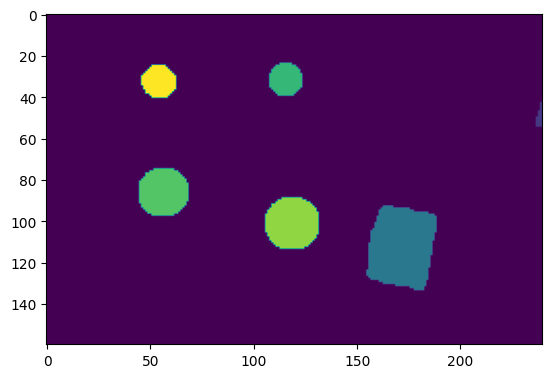

In [38]:
plt.imshow(np.load(os.path.join(train_dataset_segmentation_model.video_folders[0], 'mask.npy'))[0])
# np.unique(np.load(os.path.join(train_dataset.video_folders[0], 'mask.npy'))[0])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


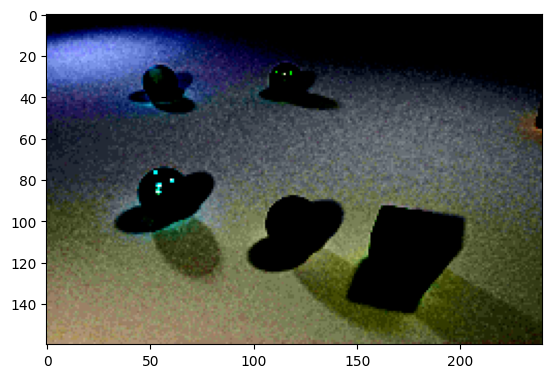

In [39]:
plt.imshow(train_dataset_segmentation_model[0][0].permute(1, 2, 0))

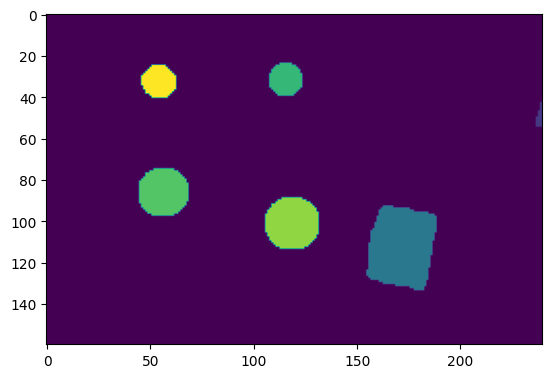

In [40]:
plt.imshow(train_dataset_segmentation_model[0][1])
# np.unique(train_dataset[0][1])

## Encoder-Decoder Architecture

In [41]:
class EarlyStopper:
    def __init__(self, patience=1, min_delta=0):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.min_validation_loss = np.inf

    def early_stop(self, validation_loss):
        if validation_loss < self.min_validation_loss:
            self.min_validation_loss = validation_loss
            self.counter = 0
        elif validation_loss > (self.min_validation_loss + self.min_delta):
            self.counter += 1
            if self.counter >= self.patience:
                return True
        return False

In [42]:
class SegmentationModel(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(SegmentationModel, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, 32, 3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, 3, padding=1)
        self.conv3 = nn.Conv2d(64, 128, 3, padding=1)
        self.conv4 = nn.Conv2d(in_channels, 64, 1)
        
        self.convtranspose1 = nn.ConvTranspose2d(128, 64, 2, stride=2)
        self.fc2 = nn.Linear(64, out_channels)
        
        self.relu = nn.ReLU()
    
    def forward(self, input):
        images = self.relu(self.conv1(input))
        images = self.relu(self.conv2(images))
        images = self.relu(self.conv3(images))
        images = F.max_pool2d(images, 2)
        images = self.relu(self.convtranspose1(images))
        images = images + self.relu(self.conv4(input))
        images = images.permute(0, 2, 3, 1)
        images = self.fc2(images)
        images = images.permute(0, 3, 1, 2)
        
        return images

In [43]:
def validate_segmentation_model(model, val_loader, criterion, device):
    accuracies, losses = [], []
    model.eval()
    with torch.no_grad():
        for batch in val_loader:
            images, masks = batch
            images, masks = images.to(device), masks.long().to(device)
            outputs = model(images)
            # outputs = transforms.functional.resize(outputs.permute(0, 3, 1, 2),
            #                                        size=masks.shape[-2:], antialias=None)
            loss = criterion(outputs, masks)
            losses.append(loss.item())
            
            # calculate accuracy
            pred = torch.argmax(outputs, dim=1)
            # only the pixels that are not background are considered
            pred = pred[masks != 0]
            masks = masks[masks != 0]
            correct = (pred == masks).sum().item()
            accuracies.append(correct / masks.numel())
    return np.mean(accuracies), np.mean(losses)

In [44]:
# Train on the dataset
def train_segmentation_model(model, train_loader, epochs, criterion, optimizer, 
          val_loader=None, scheduler=None, device='cpu', early_stopper=None, save=True):
    model.train()
    best_loss = np.inf
    for epoch in range(epochs):
        losses = []
        for (images, masks) in tqdm(train_loader):
            optimizer.zero_grad()
            images, masks = images.to(device), masks.long().to(device)
            outputs = model(images)
            loss = criterion(outputs, masks)
            losses.append(loss.item())
            loss.backward()
            optimizer.step()
        stmt = f"Epoch {epoch+1}/{epochs} | Train Loss: {np.mean(losses):.4f}"
        if val_loader:
            val_acc, val_loss = validate_segmentation_model(model, val_loader, criterion, device)
            stmt += f" | Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.4f}"
            
            if val_loss < best_loss and save:
                best_loss = val_loss
                print("Saving the best model")
                torch.save(model.state_dict(), f'best_model.pth')
                
            if early_stopper and early_stopper.early_stop(loss):
                print("Early stopping")
                break
        
        if scheduler:
            scheduler.step()
            stmt += f" | LR: {scheduler.get_last_lr()[0]:.6f}"
        
        print(stmt)

In [45]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [46]:
from torch.utils.data import Subset
import random

# subset of train dataset and val dataset
# train_subset_segmentation_model = Subset(train_dataset_segmentation_model, [10])
# train_loader = DataLoader(train_subset, batch_size=1, shuffle=True)

# val_subset = Subset(val_dataset, random.sample(range(0, len(val_dataset)), 4))
# val_subset_segmentation_model = Subset(val_dataset_segmentation_model, [10])
# val_subset = train_subset
# val_loader = DataLoader(val_subset, batch_size=1, shuffle=True)
# val_mask_loader = DataLoader(val_subset, batch_size=1, shuffle=True)
# train_loader_segmentation_model = DataLoader(train_subset_segmentation_model, 
#                                              batch_size=1, shuffle=True)
# val_loader_segmentation_model = DataLoader(val_subset_segmentation_model, 
#                                            batch_size=1, shuffle=True)

train_loader_segmentation_model = DataLoader(train_dataset_segmentation_model, 
                                             batch_size=64, shuffle=True)
val_loader_segmentation_model = DataLoader(val_dataset_segmentation_model, 
                                           batch_size=64, shuffle=True)

segmodel = SegmentationModel(3, 49)
segmodel.load_state_dict(torch.load('best_model.pth', device), strict=False)
segmodel.to(device)
optimizer = torch.optim.Adam(segmodel.parameters(), lr=0.01)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=10, eta_min=0.0001)
criterion = nn.CrossEntropyLoss()
early_stopper = EarlyStopper(patience=100, min_delta=0.001)
# train_segmentation_model(segmodel, train_loader_segmentation_model, epochs=100, 
#       criterion=criterion, optimizer=optimizer, 
#       val_loader=train_loader_segmentation_model, scheduler=scheduler, 
#       device=device, early_stopper=early_stopper, save=False)

RuntimeError: CUDA error: out of memory
CUDA kernel errors might be asynchronously reported at some other API call, so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1.
Compile with `TORCH_USE_CUDA_DSA` to enable device-side assertions.


In [ ]:
# Normal
# Epoch 1/10 | Train Loss: 0.0140 | Val Loss: 0.4873 | Val Acc: 0.1130 | LR: 0.009758
# Epoch 10/10 | Train Loss: 0.0293 | Val Loss: 0.3704 | Val Acc: 0.0033 | LR: 0.000100

# Skip Connection
# Epoch 1/10 | Train Loss: 0.2265 | Val Loss: 0.4270 | Val Acc: 0.0674 | LR: 0.009758
# Epoch 10/10 | Train Loss: 0.0230 | Val Loss: 1.0666 | Val Acc: 0.0073 | LR: 0.000100

In [ ]:
# # load pre-trained model
# segmodel.load_state_dict(torch.load('best_model.pth', map_location=torch.device(device)))

In [ ]:
# val_subset = Subset(val_dataset, random.sample(range(0, len(val_dataset)), 4))
val_subset = Subset(train_dataset_segmentation_model, [10])
val_loader = DataLoader(val_subset, batch_size=1, shuffle=True)
val_acc, val_loss = validate_segmentation_model(segmodel, val_loader, criterion, device)
print(f"Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.4f}")

Val Loss: 0.0106 | Val Acc: 0.9510


In [ ]:
# np.unique(outputs.detach().cpu().numpy(), return_counts=True)

In [24]:
np.unique(train_dataset_segmentation_model[10][1].numpy())

array([ 0,  5, 12, 20, 22, 25, 30], dtype=uint8)

In [25]:
# Run inference on one training image

outputs = segmodel(train_dataset_segmentation_model[10][0].unsqueeze(0).to(device))
outputs = torch.argmax(outputs, dim=1).squeeze(0).detach().cpu()

axis = plt.subplot(1, 2, 1)
# axis.imshow(train_dataset[0][0].permute(1, 2, 0))
# axis.imshow(train_dataset[0][1])
axis.imshow(outputs)
# print(outputs.shape, torch.argmax(outputs, dim=1).squeeze(0).detach().cpu().shape, train_dataset[0][1].shape)
plt.show()

RuntimeError: CUDA error: out of memory
CUDA kernel errors might be asynchronously reported at some other API call, so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1.
Compile with `TORCH_USE_CUDA_DSA` to enable device-side assertions.


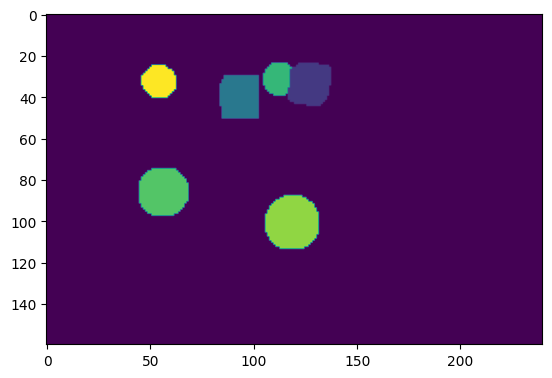

In [26]:
plt.imshow(train_dataset_segmentation_model[10][1])

## Seq2Seq for Mask

In [31]:
# # Creating a custom dataset for frames
# class SegmentationDataset(Dataset):
#     def __init__(self, root_folder, img_transforms=None, mask_transforms=None):
#         self.root_folder = root_folder
#         self.img_transforms = img_transforms
#         self.mask_transforms = mask_transforms
        
#         # Get all the folders in the root folder
#         self.video_folders = os.listdir(root_folder)
#         self.video_folders.sort()
#         self.video_folders = [os.path.join(root_folder, folder) for folder in self.video_folders]
#         self.video_folders = [folder for folder in self.video_folders if os.path.isdir(folder)]
        
#     def __len__(self):
#         return len(self.video_folders) * 22
    
#     def __getitem__(self, idx):
#         folder = self.video_folders[idx//22]
#         files = os.listdir(folder)
#         files = [file for file in files if file.endswith('.png')]
#         # sorted on numeric index
#         files = sorted(files, key=lambda x: int(x.split('.')[0].split('_')[1]))
        
#         image = plt.imread(os.path.join(folder, files[idx%22]))
#         # permute the dimensions to make it (C, H, W)
#         image = np.transpose(image, (2, 0, 1))
#         # 22 masks for each video
#         mask = np.load(os.path.join(folder, 'mask.npy'))[idx%22]
#         # print(f"folder idx: {idx//22} image folder: {folder}, image file: {files[idx%22]}, mask idx: {idx%22}")
        
#         if self.img_transforms:
#             image = self.img_transforms(image)
        
#         if self.mask_transforms:
#             mask = self.mask_transforms(mask)
        
#         return image, mask

# img_transformations = transforms.Compose([
#     torch.from_numpy,
#     # transforms.Resize(40, antialias=None),
#     transforms.Normalize(mean=[0.5061, 0.5045, 0.5008], std=[0.0571, 0.0567, 0.0614])
#     ])
# mask_transformations = transforms.Compose([torch.from_numpy])

# train_dataset = SegmentationDataset(root_folder='Dataset_Student/train', 
#                                     img_transforms=img_transformations, 
#                                     mask_transforms=mask_transformations)
# val_dataset = SegmentationDataset(root_folder='Dataset_Student/val', 
#                                   img_transforms=img_transformations,
#                                   mask_transforms=mask_transformations)

## Video Frame Dataset

In [32]:
from torchvision import transforms

class VideoFrameDataset(Dataset):
    def __init__(self, root_folder, transforms=None, labeled=True, model=None):
        self.root_folder = root_folder
        self.transforms = transforms
        self.labeled = labeled
        self.model = model
        
        # Get all the folders in the root folder
        self.video_folders = os.listdir(root_folder)
        self.video_folders.sort()
        self.video_folders = [os.path.join(root_folder, folder) for folder in self.video_folders]
        print(f"Length of video folders: {len(self.video_folders)}")
        self.video_folders = [folder for folder in self.video_folders if os.path.isdir(folder)]
        print(f"Length of dir: {len(self.video_folders)}")
        
    def __len__(self):
        return len(self.video_folders)*11
    
    def __getitem__(self, idx):
        video_folder = self.video_folders[idx//11]
        frame_idx = idx%11
        if self.labeled:
            # print(video_folder, frame_idx)
            masks = np.load(os.path.join(video_folder, 'mask.npy'))
            # print(masks.shape)
            frames = masks[frame_idx:frame_idx+11]
            label = masks[frame_idx+11]
        else:
            files = [frame for frame in os.listdir(video_folder) if frame.endswith('.png')]
            files = sorted(files, key=lambda x: int(x.split('.')[0].split('_')[1]))
            images = [plt.imread(os.path.join(video_folder, frame)) for frame in files]
            frames = np.transpose(np.array(images[frame_idx:frame_idx+11]), (0, 3, 1, 2))
            label = np.transpose(np.array(images[frame_idx+11]), (2, 0, 1))
            
        if self.transforms:
            frames = self.transforms(frames)
            label = self.transforms(label)
        
        return frames, label
    
transformations = transforms.Compose([
    torch.from_numpy,
    # transforms.Resize(40, antialias=None)
])

labeled_dataset = VideoFrameDataset('Dataset_Student/train', transforms=transformations)
trick_dataset = VideoFrameDataset('Dataset_Student/train', transforms=transforms.Compose([
                                          torch.from_numpy,
                                          transforms.Normalize(mean=[0.5061, 0.5045, 0.5008], std=[0.0571, 0.0567, 0.0614])
                                          ]), 
                                      labeled=False, model=segmodel)
unlabeled_dataset = VideoFrameDataset('Dataset_Student/unlabeled', 
                                      transforms=transforms.Compose([
                                          torch.from_numpy,
                                          transforms.Normalize(mean=[0.5061, 0.5045, 0.5008], std=[0.0571, 0.0567, 0.0614])
                                          ]), 
                                      labeled=False, model=segmodel)
val_dataset = VideoFrameDataset('Dataset_Student/val', transforms=transformations)

Length of video folders: 1000
Length of dir: 1000
Length of video folders: 1000
Length of dir: 1000
Length of video folders: 13000
Length of dir: 13000
Length of video folders: 1000
Length of dir: 1000


In [33]:
print(labeled_dataset[0][0].shape, labeled_dataset[0][1].shape)
print(unlabeled_dataset[0][0].shape, unlabeled_dataset[0][1].shape)
print(val_dataset[0][0].shape, val_dataset[0][1].shape)
print(len(labeled_dataset), len(unlabeled_dataset), len(val_dataset))

torch.Size([11, 160, 240]) torch.Size([160, 240])
torch.Size([11, 3, 160, 240]) torch.Size([3, 160, 240])
torch.Size([11, 160, 240]) torch.Size([160, 240])
11000 143000 11000


In [34]:
# (labeled_dataset[13][0][0] == labeled_dataset[11][0][2]).all()

In [35]:
# # _, axis = plt.subplots(3, 2)
# # axis[0][0].imshow(labeled_dataset[0][0][-1])
# # axis[0][1].imshow(labeled_dataset[0][1])
# # axis[2][0].imshow(labeled_dataset[0][0][1])
# # axis[2][1].imshow(labeled_dataset[1][1])
# # axis[2][0].imshow(labeled_dataset[1][0][0])
# # axis[2][1].imshow(labeled_dataset[1][1])
# _, axis = plt.subplots(4, 6)
# for j in range(2):
#     for i in range(11):
#         axis[2*j+i//6][i%6].imshow(labeled_dataset[j][0][i])
#     axis[2*j+1][5].imshow(labeled_dataset[j][1])

## Convolutional LSTM implementation

Code from: https://github.com/ndrplz/ConvLSTM_pytorch

In [36]:
class ConvLSTMCell(nn.Module):

    def __init__(self, input_dim, hidden_dim, kernel_size, bias):
        """
        Initialize ConvLSTM cell.

        Parameters
        ----------
        input_dim: int
            Number of channels of input tensor.
        hidden_dim: int
            Number of channels of hidden state.
        kernel_size: (int, int)
            Size of the convolutional kernel.
        bias: bool
            Whether or not to add the bias.
        """

        super(ConvLSTMCell, self).__init__()

        self.input_dim = input_dim
        self.hidden_dim = hidden_dim

        self.kernel_size = kernel_size
        self.padding = kernel_size[0] // 2, kernel_size[1] // 2
        self.bias = bias

        self.conv = nn.Conv2d(in_channels=self.input_dim + self.hidden_dim,
                              out_channels=4 * self.hidden_dim,
                              kernel_size=self.kernel_size,
                              padding=self.padding,
                              bias=self.bias)

    def forward(self, input_tensor, cur_state):
        h_cur, c_cur = cur_state

        combined = torch.cat([input_tensor, h_cur], dim=1)  # concatenate along channel axis

        combined_conv = self.conv(combined)
        cc_i, cc_f, cc_o, cc_g = torch.split(combined_conv, self.hidden_dim, dim=1)
        i = torch.sigmoid(cc_i)
        f = torch.sigmoid(cc_f)
        o = torch.sigmoid(cc_o)
        g = torch.tanh(cc_g)

        c_next = f * c_cur + i * g
        h_next = o * torch.tanh(c_next)
        # print(f"self.hidden_dim: {self.hidden_dim}, h_next: {h_next.shape}, c_next: {c_next.shape}")

        return h_next, c_next

    def init_hidden(self, batch_size, image_size):
        height, width = image_size
        return (torch.zeros(batch_size, self.hidden_dim, height, width, device=self.conv.weight.device),
                torch.zeros(batch_size, self.hidden_dim, height, width, device=self.conv.weight.device))

In [37]:
class ConvLSTM(nn.Module):

    """

    Parameters:
        input_dim: Number of channels in input
        hidden_dim: Number of hidden channels
        kernel_size: Size of kernel in convolutions
        num_layers: Number of LSTM layers stacked on each other
        batch_first: Whether or not dimension 0 is the batch or not
        bias: Bias or no bias in Convolution
        return_all_layers: Return the list of computations for all layers
        Note: Will do same padding.

    Input:
        A tensor of size B, T, C, H, W or T, B, C, H, W
    Output:
        A tuple of two lists of length num_layers (or length 1 if return_all_layers is False).
            0 - layer_output_list is the list of lists of length T of each output
            1 - last_state_list is the list of last states
                    each element of the list is a tuple (h, c) for hidden state and memory
    Example:
        >> x = torch.rand((32, 10, 64, 128, 128))
        >> convlstm = ConvLSTM(64, 16, 3, 1, True, True, False)
        >> _, last_states = convlstm(x)
        >> h = last_states[0][0]  # 0 for layer index, 0 for h index
    """

    def __init__(self, input_dim, hidden_dim, kernel_size, num_layers,
                 batch_first=False, bias=True, return_all_layers=False):
        super(ConvLSTM, self).__init__()

        self._check_kernel_size_consistency(kernel_size)

        # Make sure that both `kernel_size` and `hidden_dim` are lists having len == num_layers
        kernel_size = self._extend_for_multilayer(kernel_size, num_layers)
        hidden_dim = self._extend_for_multilayer(hidden_dim, num_layers)
        if not len(kernel_size) == len(hidden_dim) == num_layers:
            raise ValueError('Inconsistent list length.')

        self.input_dim = input_dim
        self.hidden_dim = hidden_dim
        self.kernel_size = kernel_size
        self.num_layers = num_layers
        self.batch_first = batch_first
        self.bias = bias
        self.return_all_layers = return_all_layers

        cell_list = []
        for i in range(0, self.num_layers):
            cur_input_dim = self.input_dim if i == 0 else self.hidden_dim[i - 1]

            cell_list.append(ConvLSTMCell(input_dim=cur_input_dim,
                                          hidden_dim=self.hidden_dim[i],
                                          kernel_size=self.kernel_size[i],
                                          bias=self.bias))

        self.cell_list = nn.ModuleList(cell_list)

    def forward(self, input_tensor, hidden_state=None):
        """

        Parameters
        ----------
        input_tensor: todo
            5-D Tensor either of shape (t, b, c, h, w) or (b, t, c, h, w)
        hidden_state: todo
            None. todo implement stateful

        Returns
        -------
        last_state_list, layer_output
        """
        if not self.batch_first:
            # (t, b, c, h, w) -> (b, t, c, h, w)
            input_tensor = input_tensor.permute(1, 0, 2, 3, 4)

        b, _, _, h, w = input_tensor.size()

        # Implement stateful ConvLSTM
        if hidden_state is None:
            # Since the init is done in forward. Can send image size here
            hidden_state = self._init_hidden(batch_size=b,
                                             image_size=(h, w))
        elif len(hidden_state) != self.num_layers:
            raise NotImplementedError("Hidden state is not implemented for len(hidden_state) != self.num_layers")

        layer_output_list = []
        last_state_list = []

        seq_len = input_tensor.size(1)
        cur_layer_input = input_tensor

        for layer_idx in range(self.num_layers):

            h, c = hidden_state[layer_idx]
            output_inner = []
            for t in range(seq_len):
                h, c = self.cell_list[layer_idx](input_tensor=cur_layer_input[:, t, :, :, :],
                                                 cur_state=[h, c])
                output_inner.append(h)
            # print(f"layer_idx {layer_idx}, h {h.shape}, c {c.shape}")

            layer_output = torch.stack(output_inner, dim=1)
            cur_layer_input = layer_output

            layer_output_list.append(layer_output)
            last_state_list.append([h, c])

        if not self.return_all_layers:
            layer_output_list = layer_output_list[-1:]
            last_state_list = last_state_list[-1:]
        # print("layer_output_list", layer_output_list[-1].shape)
        # print("last_state_list", last_state_list[-1][0].shape)
        # print(f"self.num_layers {self.num_layers}, self.hidden_dim {self.hidden_dim}")
        # print(f"self.cell_list {self.cell_list[-1].hidden_dim}")

        return layer_output_list, last_state_list

    def _init_hidden(self, batch_size, image_size):
        init_states = []
        for i in range(self.num_layers):
            init_states.append(self.cell_list[i].init_hidden(batch_size, image_size))
        return init_states

    @staticmethod
    def _check_kernel_size_consistency(kernel_size):
        if not (isinstance(kernel_size, tuple) or
                (isinstance(kernel_size, list) and all([isinstance(elem, tuple) for elem in kernel_size]))):
            raise ValueError('`kernel_size` must be tuple or list of tuples')

    @staticmethod
    def _extend_for_multilayer(param, num_layers):
        if not isinstance(param, list):
            param = [param] * num_layers
        return param

In [38]:

class seq2seq(nn.Module):
    def __init__(self, input_dim, hidden_dim, kernel_size, num_layers, 
                 batch_first, bias, return_all_layers, segmodel=segmodel):
        super(seq2seq, self).__init__()
        self.segmodel = segmodel
        # self.conv2d = nn.Conv2d(49, 49, 2, stride=2)
        self.maxpool = nn.MaxPool2d(8, stride=8)
        self.conv_lstm = ConvLSTM(input_dim, hidden_dim, kernel_size, 
                                  num_layers, batch_first, bias, return_all_layers)
        self.fc = nn.Linear(hidden_dim[-1], 49)
    
    def forward(self, x, masks, labeled=True):
        # x.shape: 4, 11, 49, 160, 240
        if not labeled:
            x = x.view(-1, 3, x.shape[3], x.shape[4])
            x = self.segmodel(x)
            x = x.view(-1, 11, x.shape[1], x.shape[2], x.shape[3])
            
            masks = self.segmodel(masks)
            # assert (x.softmax(dim=2).argmax(dim=2) == x.argmax(dim=2)).all()
            # assert (masks.softmax(dim=1).argmax(dim=1) == masks.argmax(dim=1)).all()
            x, masks = x.softmax(dim=2), masks.softmax(dim=1)
        # print(np.unique(masks.detach().cpu().numpy()))

        _, output = self.conv_lstm(x)
        output = self.fc(output[0][0].permute(0, 2, 3, 1))
        output = output.permute(0, 3, 1, 2)
        return output, masks

### Training

In [39]:
# # Load checkpoint
# checkpoint = torch.load('best_model.pt')
# model.load_state_dict(checkpoint['model_state_dict'])
# optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
# epoch = checkpoint['epoch']
# loss = checkpoint['loss']

In [40]:
def validate_seq2seq(model, val_loader, criteria, device=device):
    model.eval()
    losses, accuracies = [], []
    with torch.no_grad():
        for (images, masks) in tqdm(val_loader):
            images = F.one_hot(images.long(), num_classes=49).permute(0, 1, 4, 2, 3).to(device)
            masks = F.one_hot(masks.long(), num_classes=49).permute(0, 3, 1, 2).float().to(device)
            output, masks = model(images, masks)
            loss = criteria(output, masks)
            # print(output.shape, masks.shape)
            pred = output.argmax(dim=1)
            masks = masks.argmax(dim=1)
            pred = pred[masks != 0]
            masks = masks[masks != 0]
            prediction = (pred == masks).sum().item()
            accuracies.append(prediction/masks.numel())
            losses.append(loss.item())
    return np.mean(losses), np.mean(accuracies)

In [48]:
def train_seq2seq(model, val_loader, optimizer, criteria, epochs, 
          device, scheduler, labeled_loader=None, unlabeled_loader=None,
          train_loader=None, val_mask_loader=None, segm_epochs=10, early_stopper=None, save=True):
    best_loss = np.inf
    for epoch in range(epochs):
        out_string = f"Epoch {epoch+1}/{epochs}"
        
        if train_loader is not None:
            # Training for segmentation model
            model.train()
            losses = []
            for _ in range(segm_epochs):
                for (images, masks) in tqdm(train_loader):
                    optimizer.zero_grad()
                    images, masks = images.to(device), masks.long().to(device)
                    outputs = model.segmodel(images)
                    loss = criterion(outputs, masks)
                    losses.append(loss.item())
                    loss.backward()
                    optimizer.step()
            out_string += f" | Segm Loss: {np.mean(losses):.4f}"
                
            if val_mask_loader:
                accuracies, losses = [], []
                model.eval()
                with torch.no_grad():
                    for (images, masks) in tqdm(val_mask_loader):
                        images, masks = images.to(device), masks.long().to(device)
                        outputs = model.segmodel(images)
                        loss = criterion(outputs, masks)
                        losses.append(loss.item())
                        
                        # calculate accuracy
                        pred = torch.argmax(outputs, dim=1)
                        # only the pixels that are not background are considered
                        pred = pred[masks != 0]
                        masks = masks[masks != 0]
                        correct = (pred == masks).sum().item()
                        accuracies.append(correct / masks.numel())
                val_Acc, val_loss = np.mean(accuracies), np.mean(losses)
                out_string += f" | Segm Val Loss: {val_loss:.4f} | Segm Val Acc: {val_Acc:.4f}"
    
        if labeled_loader is not None:
            # Training for frame prediction model
            model.train()
            losses = []
            # for batch_idx, (images, masks) in enumerate(tqdm(labeled_loader)):
            for (images, masks) in tqdm(labeled_loader):
                images = F.one_hot(images.long(), num_classes=49).permute(0, 1, 4, 2, 3).to(device)
                masks = F.one_hot(masks.long(), num_classes=49).permute(0, 3, 1, 2).float().to(device)
                optimizer.zero_grad()
                output, masks = model(images, masks)
                # output and mask should be single frame
                # loss = criteria(output[:, 0], masks[:, 0])
                loss = criteria(output, masks)
                loss.backward()
                optimizer.step()
                losses.append(loss.item())
            out_string += f", Labeled Loss: {np.mean(losses):.2f}"
        
        if unlabeled_loader is not None:
            model.train()
            losses = []
            for (images, masks) in tqdm(unlabeled_loader):
                images, masks = images.to(device), masks.to(device)
                optimizer.zero_grad()
                output, masks = model(images, masks, False)
                loss = criteria(output, masks.softmax(dim=1))
                loss.backward()
                optimizer.step()
                losses.append(loss.item())
            out_string += f", Unlabeled Loss: {np.mean(losses):.2f}"
        
        val_loss, mean_acc = validate_seq2seq(model, val_loader, criteria, device)
        if val_loss < best_loss and save:
                best_loss = val_loss
                print("Saving the best model")
                torch.save(model.state_dict(), f'complete_best_model.pth')
        out_string += f", Val Loss: {val_loss:.2f}, Mean Acc: {mean_acc:.4f}"
        out_string += f", LR: {scheduler.get_last_lr()[0]:.4f}"
                
        print(out_string)
        scheduler.step()
        
        if early_stopper is not None and early_stopper.early_stop(val_loss):
            print("Early stopping")
            break
            

In [46]:
from torch.optim import lr_scheduler

model = seq2seq(input_dim=49,
             hidden_dim=[64, 64, 128],
             num_layers=3,
            #  hidden_dim=[64],
            #  num_layers=1,
             kernel_size=(3, 3),
             batch_first=True,
             bias=True,
             return_all_layers=False)

cuda_count = torch.cuda.device_count()
if cuda_count > 1:
    print("Let's use", cuda_count, "GPUs!")
    # dim = 0 [30, xxx] -> [10, ...], [10, ...], [10, ...] on 3 GPUs
    model = nn.DataParallel(model)
model.to(device)

# original saved file with DataParallel
# state_dict = torch.load('complete_best_model.pth', map_location=torch.device(device))
# # create new OrderedDict that does not contain `module.`
# from collections import OrderedDict
# new_state_dict = OrderedDict()
# for k, v in state_dict.items():
#     name = k[7:] # remove `module.`
#     new_state_dict[name] = v
# # load params
# model.load_state_dict(new_state_dict)
# model.load_state_dict(torch.load('complete_best_model.pth', map_location=torch.device('cpu')))

# hyperparameters
criteria = nn.CrossEntropyLoss()
# criteria = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
# scheduler = lr_scheduler.ReduceLROnPlateau(optimizer)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=10, eta_min=0.0001)
early_stopper = EarlyStopper(patience=100, min_delta=0.001)
epochs = 100

In [47]:
import random

# labeled_subset = Subset(labeled_dataset, range(1))
# unlabeled_subset = Subset(unlabeled_dataset, range(1))
# trick_subset = Subset(trick_dataset, range(1))
# train_subset_segmentation_model = Subset(train_dataset_segmentation_model, range(12))
# val_subset_segmentation_model = Subset(val_dataset_segmentation_model, range(12))

# labeled_loader = DataLoader(labeled_subset, batch_size=1, shuffle=True)
# trick_loader = DataLoader(trick_subset, batch_size=1, shuffle=True)
# unlabeled_loader = DataLoader(unlabeled_subset, batch_size=1, shuffle=True)
# val_subset_loader = DataLoader(labeled_subset, batch_size=1, shuffle=True)
# train_loader_segmentation_model = DataLoader(train_subset_segmentation_model, 
#                                              batch_size=12, shuffle=True)
# val_loader_segmentation_model = DataLoader(val_subset_segmentation_model, 
#                                            batch_size=12, shuffle=True)

labeled_loader = DataLoader(labeled_dataset, batch_size=8, shuffle=True)
unlabeled_loader = DataLoader(unlabeled_dataset, batch_size=8, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=8, shuffle=True)
train_loader_segmentation_model = DataLoader(train_dataset_segmentation_model, 
                                             batch_size=64, shuffle=True)
val_loader_segmentation_model = DataLoader(val_dataset_segmentation_model, 
                                           batch_size=64, shuffle=True)
# model.segmodel.requires_grad = False
train_seq2seq(model=model,
      val_loader=val_loader,
      optimizer=optimizer,
      criteria=criteria,
      epochs=100,
      device=device,
      scheduler=scheduler,
      labeled_loader=None,
      unlabeled_loader=unlabeled_loader,
      train_loader=train_loader_segmentation_model,
      val_mask_loader=val_loader_segmentation_model,
      segm_epochs=10,
      early_stopper=None,
      save=False)

  2%|▏         | 8/344 [00:22<15:49,  2.83s/it]


KeyboardInterrupt: 

In [263]:
x, y = next(iter(trick_loader))
x = x.view(-1, 3, x.shape[3], x.shape[4]).to(device)
x = model.segmodel(x)
x = x.view(-1, 11, x.shape[1], x.shape[2], x.shape[3]).to(device)

# y = y.view(-1, 3, y.shape[2], y.shape[3]).to(device)
y = model.segmodel(y.to(device))
# y = y.view(-1, y.shape[1], y.shape[2], y.shape[3]).to(device)
print(x.shape, y.shape)

# x = x.view(-1, 3, x.shape[3], x.shape[4])
# x = self.segmodel(x)
# x = x.view(-1, 11, x.shape[1], x.shape[2], x.shape[3])

# masks = self.segmodel(masks)

torch.Size([1, 11, 49, 160, 240]) torch.Size([1, 49, 160, 240])


In [264]:
print(nn.CrossEntropyLoss()(output[0], y.softmax(dim=1)))

tensor(4.4266, device='cuda:0', grad_fn=<DivBackward1>)


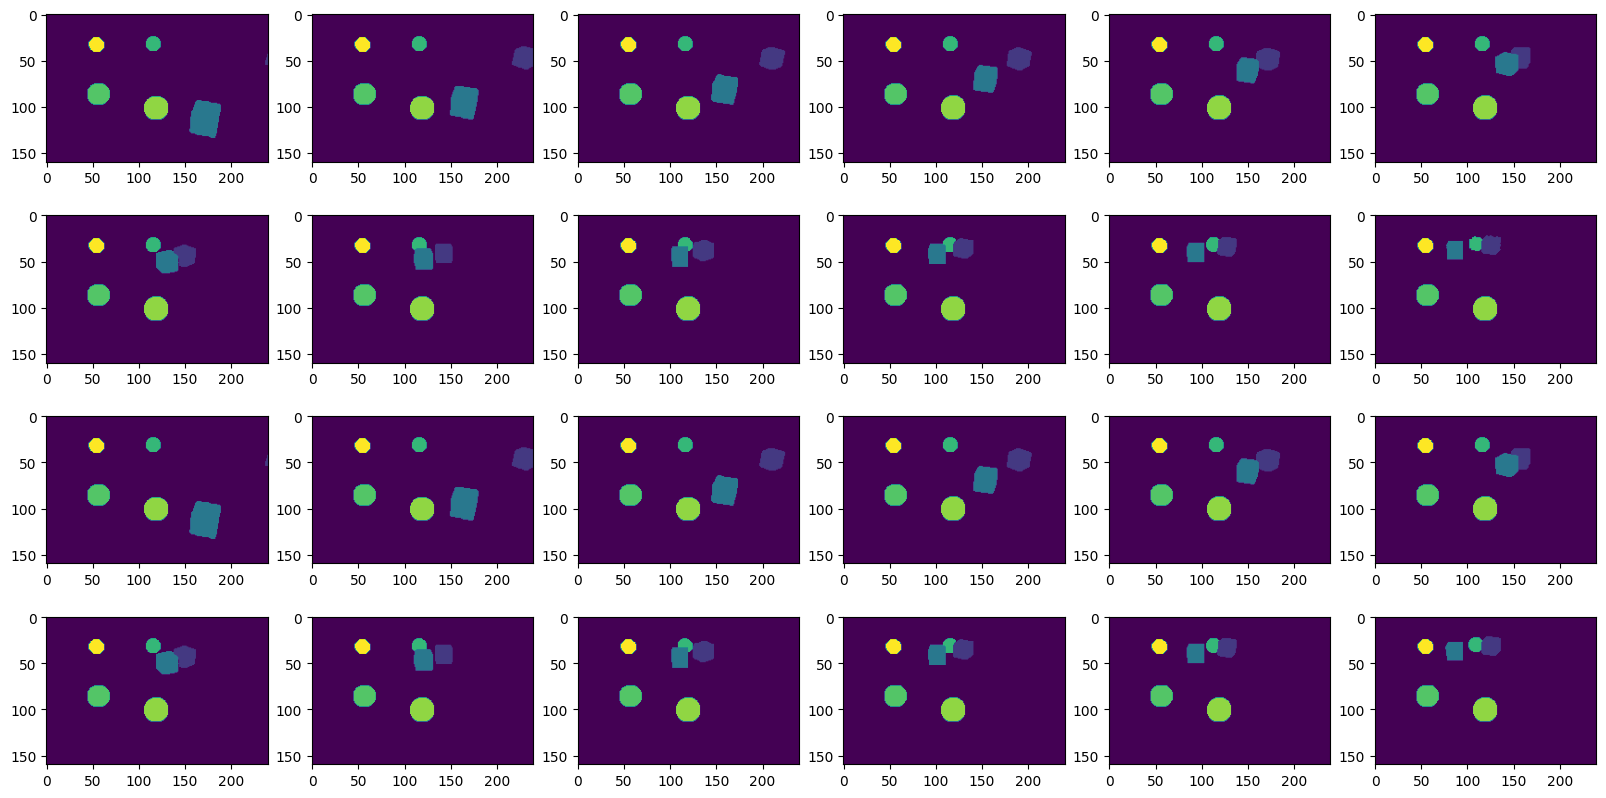

In [302]:
_, axis = plt.subplots(4, 6, figsize=(20, 10))
for i in range(11):
    axis[i//6, i%6].imshow(x[0, i, :, :, :].softmax(dim=0).argmax(dim=0).cpu().numpy())
# axis[1, 5].imshow(y[0, :, :, :].argmax(dim=0).cpu().numpy())
axis[1, 5].imshow(y.softmax(dim=1)[0].softmax(dim=0).argmax(dim=0).cpu().numpy())

labels, target = next(iter(labeled_loader))
# print(labels.shape)
for i in range(11):
    # print(labels[0].shape)
    # axis[2+ i//6, i%6].imshow(labels[0, i, :, :].cpu().numpy())
    axis[2+ i//6, i%6].imshow(F.one_hot(labels[0, i, :, :].long(), num_classes=49).permute(2, 0, 1).argmax(dim=0).cpu().numpy())
# axis[3, 5].imshow(target[0, :, :].cpu().numpy())
axis[3, 5].imshow(F.one_hot(target[0, :, :].long(), num_classes=49).permute(2, 0, 1).float().argmax(dim=0).cpu().numpy())
plt.show()

TODOs:
- After trying to overfit on labeled dataset check if labeled loss is being correctly computed by getting the loss for zeroth data entry
- Plot the output to see what it prints

Observations:
- The labeled loss is going down very slowly.
- unlabeled and validation exactly the same after segmentation but still why the difference in loss?
   - The output is not visually correct, so def unlabeled loss is not correct.

Hypothesis:
- Model should be able to learn smth from labeled dataset as no noise.

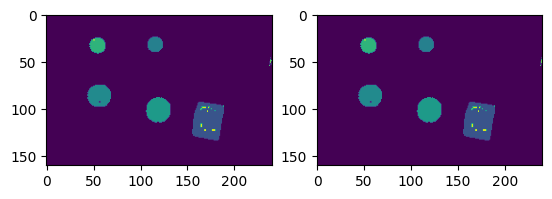

In [ ]:
# Run inference on one training image

# input = unlabeled_dataset[10][0][0].unsqueeze(0).to(device)
input = train_dataset[0][0].unsqueeze(0).to(device)
outputs = model.segmodel(input)
outputs = torch.argmax(outputs, dim=1).squeeze(0).detach().cpu()

output2 = segmodel(input)
outputs2 = torch.argmax(output2, dim=1).squeeze(0).detach().cpu()

_, axis = plt.subplots(1, 2)
# axis.imshow(train_dataset[0][0].permute(1, 2, 0))
# axis.imshow(train_dataset[0][1])
axis[0].imshow(outputs)
axis[1].imshow(outputs2)
# print(outputs.shape, torch.argmax(outputs, dim=1).squeeze(0).detach().cpu().shape, train_dataset[0][1].shape)
plt.show()

In [336]:
model.eval()

output = model(F.one_hot(labeled_subset[0][0].unsqueeze(0).long(), num_classes=49).permute(0, 1, 4, 2, 3).to(device),
               F.one_hot(labeled_subset[0][1].unsqueeze(0).long(), num_classes=49).permute(0, 3, 1, 2).to(device))

print(trick_subset[0][0].unsqueeze(0).shape, trick_subset[0][1].unsqueeze(0).shape)
output2 = model(trick_subset[0][0].unsqueeze(0).to(device),
                trick_subset[0][1].unsqueeze(0).to(device), False)

torch.Size([1, 11, 3, 160, 240]) torch.Size([1, 3, 160, 240])


In [337]:
print(nn.CrossEntropyLoss()(output[0], output[1].float().to(device)))
print(nn.CrossEntropyLoss()(output2[0], output2[1].softmax(dim=1).float().to(device)))

tensor(2.9322, device='cuda:0', grad_fn=<DivBackward1>)
tensor(3.8728, device='cuda:0', grad_fn=<DivBackward1>)


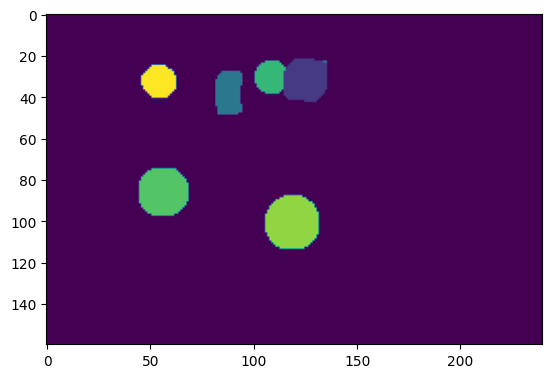

In [338]:
plt.imshow(output[0].argmax(1)[0].cpu())

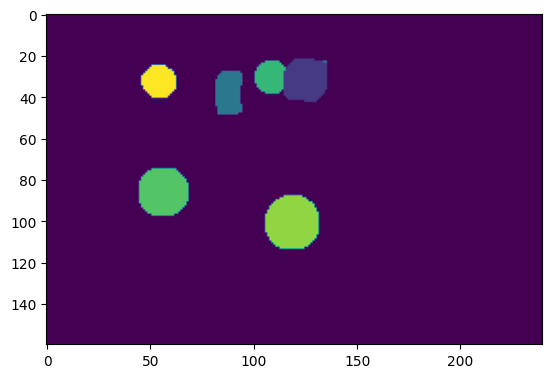

In [339]:
plt.imshow(output2[0].argmax(1)[0].cpu())

In [136]:
F.cross_entropy(output[0], labeled_dataset[0][1].long().unsqueeze(0).to(device)),

(tensor(0.0183, device='cuda:0', grad_fn=<NllLoss2DBackward0>),)

In [137]:
F.cross_entropy(output[0], labeled_dataset[0][0][-1].long().unsqueeze(0).to(device))

tensor(0.0582, device='cuda:0', grad_fn=<NllLoss2DBackward0>)

In [ ]:
print(unlabeled_dataset[0][0].shape, unlabeled_dataset[0][1].shape)

In [48]:
output[0].shape

torch.Size([1, 11, 49, 20, 30])

In [ ]:
# torch.save({
#             'epoch': epochs,
#             'model_state_dict': model.state_dict(),
#             'optimizer_state_dict': optimizer.state_dict(),
#             'loss': 1187.166111328125,
#             }, 'best_model.pt')

# # load model from here --> 
# # https://pytorch.org/tutorials/recipes/recipes/saving_and_loading_a_general_checkpoint.html